# Modelos de classificação com Python

Para esta aplicação, estaremos trabalhando com o [Conjunto de dados do heart da Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction).

Vamos tentar montar um algoritmo de modelos classificação de indivíduos doentes do coração ou não utilizando regressão logística no Python.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix, matthews_corrcoef, f1_score
%matplotlib inline

## Os dados

Vamos começar lendo o arquivo heart.csv em um DataFrame pandas.

In [2]:
heart = pd.read_csv('heart.csv')

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Análise de dados exploratórios

Vamos começar algumas análises de dados exploratórios. Vamos calcular as principais estatísticas para o conjunto de dados!

In [4]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Se você observar, há presença de valores 0 em variáveis que humanamente não fazem sentido, o que parece ser uma forma de escrever valores (NaN), dessa forma, vamos retornar os valores 0 para NaN e depois vamos aplicar uma técnica de interpolação linear para estimar os valores NaN.

In [5]:
heart['RestingBP'].replace(0, np.nan, inplace = True)

In [6]:
heart['Cholesterol'].replace(0, np.nan, inplace = True)

# Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados! Como podemos notar há valores NaN no conjunto de dados, principalmente na variável colesterol.

<AxesSubplot:>

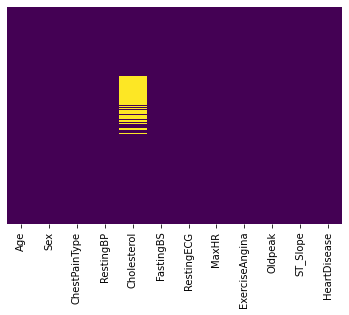

In [7]:
sns.heatmap(heart.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Análise descritiva dos dados via gráficos de barras e histogramas

Vamos visualizar todas as variáveis no conjunto de dados para detectarmos alguns padrões! Nota-se, por exemplo, que a variável resposta HeartDiasease estão balanceados, isto é importante, pois a forma de splitar os dados para treino e teste, podem influênciar no viés das estimativas dos parâmetros do modelo, e, consequentemente nos valores preditos ou previstos para o conjunto de dados.

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

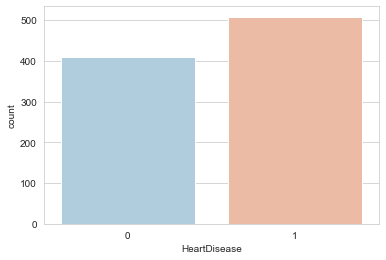

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='HeartDisease',data=heart,palette='RdBu_r')

Vamos verificar algumas variáveis conjuntamente para observarmos alguns padrões. Neste caso consideramos a variável resposta (Heart Disease) com a variável (Sex).

<AxesSubplot:xlabel='Sex', ylabel='count'>

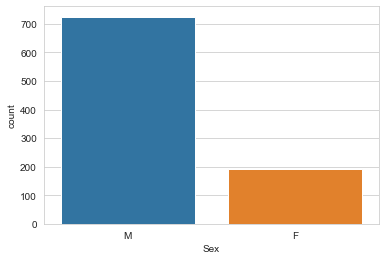

In [9]:
sns.set_style('whitegrid')
sns.countplot(x='Sex',data=heart)

Gráfico de barras da variável (ChestPainType)

<AxesSubplot:xlabel='ChestPainType', ylabel='count'>

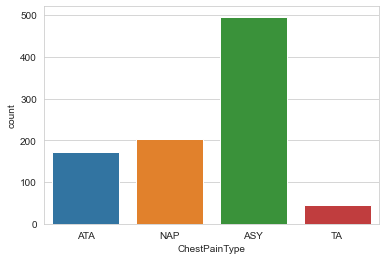

In [10]:
sns.set_style('whitegrid')
sns.countplot(x='ChestPainType',data=heart)

Gráfico de histograma da variável (Age).

<AxesSubplot:>

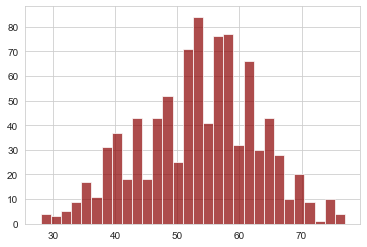

In [11]:
heart['Age'].hist(bins=30,color='darkred',alpha=0.7)

Gráfico de barras da variável (RestingECG)

<AxesSubplot:xlabel='RestingECG', ylabel='count'>

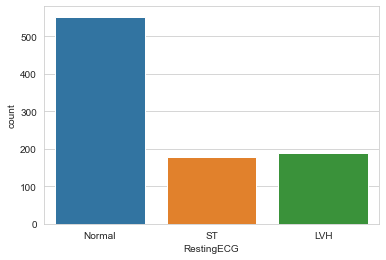

In [12]:
sns.countplot(x='RestingECG',data=heart)

<AxesSubplot:>

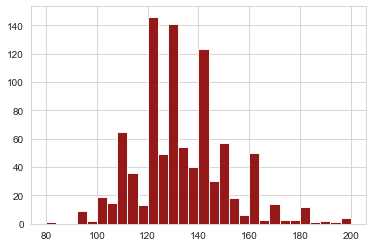

In [13]:
heart['RestingBP'].hist(bins=30,color='darkred',alpha=0.9)

<AxesSubplot:>

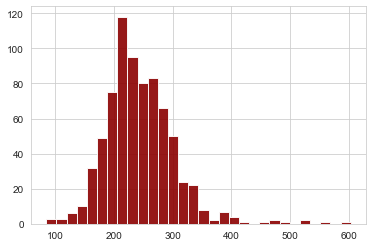

In [14]:
heart['Cholesterol'].hist(bins=30,color='darkred',alpha=0.9)

<AxesSubplot:>

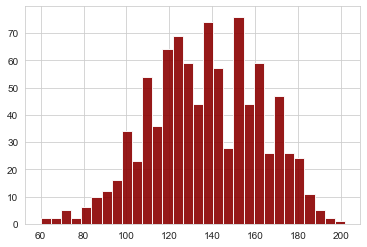

In [15]:
heart['MaxHR'].hist(bins=30,color='darkred',alpha=0.9)

<AxesSubplot:xlabel='ExerciseAngina', ylabel='count'>

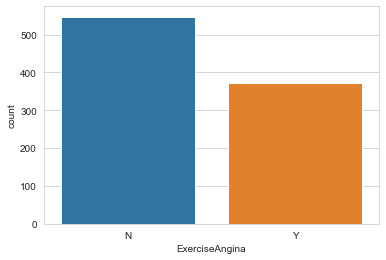

In [16]:
sns.countplot(x='ExerciseAngina',data=heart)

<AxesSubplot:>

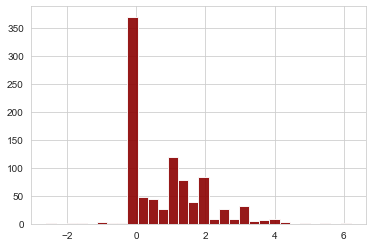

In [17]:
heart['Oldpeak'].hist(bins=30,color='darkred',alpha=0.9)

<AxesSubplot:xlabel='ST_Slope', ylabel='count'>

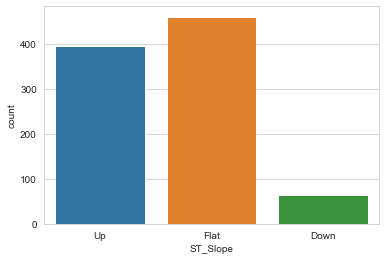

In [18]:
sns.countplot(x='ST_Slope',data=heart)


## Minerando o conjunto de dados 

Como podemos notar, algumas variáveis como RestingBP, Cholesterol apresentaram valores iguais a 0, isto é, possivelmente valores ausentes ou informações incorretos, por esta razão vamos transformar os valores iguais a 0 em NaN para que possa ser utilizado uma técnica de interpolação linear na média e os dados sejam estimados.


Agora vamos verificar esse mapa de calor novamente!

<AxesSubplot:>

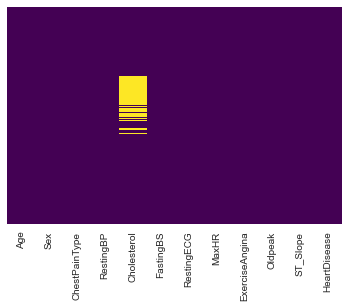

In [19]:
sns.heatmap(heart.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Convertendo as variáveis categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [20]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       917 non-null    float64
 4   Cholesterol     746 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 86.2+ KB


In [21]:
heart['Sex'] = pd.get_dummies(heart['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinaridade

In [22]:
heart['ExerciseAngina'] = pd.get_dummies(heart['ExerciseAngina'],drop_first=True)

In [23]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140.0,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160.0,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130.0,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138.0,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150.0,195.0,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110.0,264.0,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144.0,193.0,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130.0,131.0,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130.0,236.0,0,LVH,174,0,0.0,Flat,1


# Utilizando interpolação linear pela média 

In [59]:
heart = heart.fillna(heart.mean()) 

In [25]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    uint8  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    uint8  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(4), object(3), uint8(2)
memory usage: 73.6+ KB


# Transformando as variáveis ChestPainType, RestingECG, e ST_Slope me variáveis numéricas

In [26]:
to_replace = {"TA":1, "ATA": 2, "NAP":3, "ASY":4}

heart['ChestPainType'] = heart['ChestPainType'].replace(to_replace)

heart['ChestPainType'].value_counts()

4    496
3    203
2    173
1     46
Name: ChestPainType, dtype: int64

In [27]:
to_replace1 = {"Normal":1, "ST": 2, "LVH":3}

heart['RestingECG'] = heart['RestingECG'].replace(to_replace1)

heart['RestingECG'].value_counts()

1    552
3    188
2    178
Name: RestingECG, dtype: int64

In [28]:
to_replace2 = {"Up":1, "Flat": 2, "Down":3}

heart['ST_Slope'] = heart['ST_Slope'].replace(to_replace2)

heart['ST_Slope'].value_counts()

2    460
1    395
3     63
Name: ST_Slope, dtype: int64

In [29]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140.0,289.0,0,1,172,0,0.0,1,0
1,49,0,3,160.0,180.0,0,1,156,0,1.0,2,1
2,37,1,2,130.0,283.0,0,2,98,0,0.0,1,0
3,48,0,4,138.0,214.0,0,1,108,1,1.5,2,1
4,54,1,3,150.0,195.0,0,1,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,1,110.0,264.0,0,1,132,0,1.2,2,1
914,68,1,4,144.0,193.0,1,1,141,0,3.4,2,1
915,57,1,4,130.0,131.0,0,1,115,1,1.2,2,1
916,57,0,2,130.0,236.0,0,3,174,0,0.0,2,1


In [30]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    uint8  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    uint8  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(3), int64(7), uint8(2)
memory usage: 73.6 KB


### Transformando o data.frame em um objeto array para a utilização nos modelos de machine learning

In [31]:
X = heart.loc[:, heart.columns != 'HeartDisease'].to_numpy()
y = heart.loc[:, heart.columns == 'HeartDisease'].to_numpy()


Ótimo! Nossos dados estão prontos para o nosso modelo

# Construindo um modelo de Machine Learning de classificação


Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes. Como os dados são balanceados, vamos dividir os dados usualmente.

## Divisão treino-teste

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, 
                                                    random_state=101)

# Aplicando o modelo de regressão logístico

In [33]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train,y_train.ravel())

LogisticRegression(max_iter=1000)

In [34]:
predictions = logmodel.predict(X_test)

Vamos seguir em frente para avaliar o nosso modelo!

## Avaliação das métricas do modelo

Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        79
           1       0.84      0.83      0.84       105

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



In [36]:
conf_matrix = confusion_matrix(y_test,predictions)
print(conf_matrix)

[[63 16]
 [18 87]]


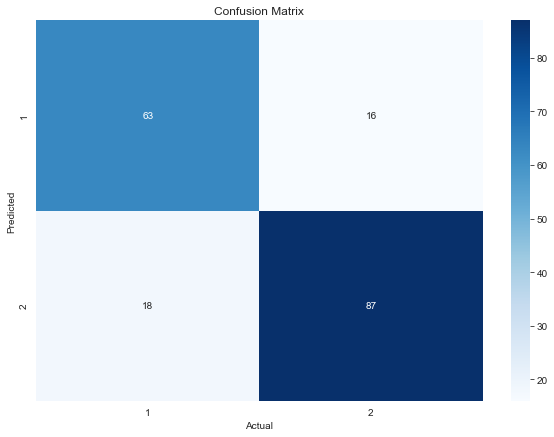

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(conf_matrix):
  labels = ['True', 'prediction']
  df_cm = pd.DataFrame(conf_matrix, index=['1','2'], columns=['1','2'])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title("Confusion Matrix")

  # plt.savefig()

plot_confusion_matrix(conf_matrix)

# Modelo de Árvore de Decisão 

In [38]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
predictions_Tree = DecisionTree.predict(X_test)
predictions_Tree

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1], dtype=int64)

## Avaliação das métricas do modelo

In [40]:
print(classification_report(y_test,predictions_Tree))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        79
           1       0.83      0.81      0.82       105

    accuracy                           0.80       184
   macro avg       0.79      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



In [41]:
conf_matrix_tree = confusion_matrix(y_test,predictions_Tree)
print(conf_matrix_tree )

[[62 17]
 [20 85]]


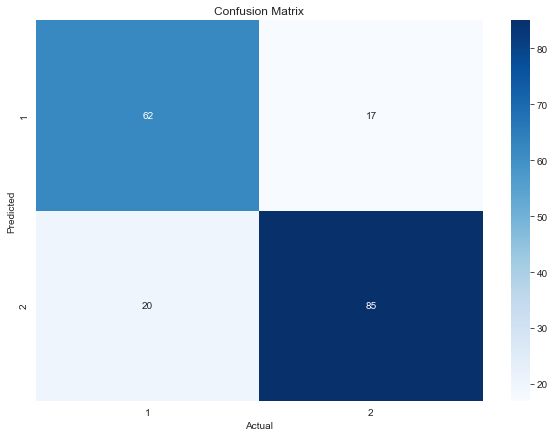

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(conf_matrix_tree):
  labels = ['True', 'prediction']
  df_cm = pd.DataFrame(conf_matrix_tree, index=['1','2'], columns=['1','2'])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title("Confusion Matrix")

  # plt.savefig()

plot_confusion_matrix(conf_matrix_tree)

# Modelo Random Forest

In [43]:
Randonmod = RandomForestClassifier()
Randonmod.fit(X_train, y_train.ravel())

RandomForestClassifier()

In [44]:
# Tunning dos parâmetros do modelo 

In [45]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 50, stop = 800, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

{'n_estimators': [50, 133, 216, 300, 383, 466, 550, 633, 716, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [46]:
#rf_random = RandomizedSearchCV(estimator = Randonmod, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 133, 216, 300, 383,
                                                         466, 550, 633, 716,
                                                         800]},
                   random_state=42, verbose=2)

In [47]:
#rf_random.best_params_

{'n_estimators': 216,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': False}

In [48]:
#Randonmod = RandomForestClassifier(n_estimators = 300, min_samples_split = 2, min_samples_leaf =1, max_features = 'auto', max_depth = 100, bootstrap = True)
Randonmod = RandomForestClassifier()
Randonmod.fit(X_train, y_train.ravel())

RandomForestClassifier(max_depth=100, n_estimators=300)

In [49]:
predictions_rd = Randonmod.predict(X_test)
predictions_rd

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

## Avaliação das métricas do modelo

In [50]:
print(classification_report(y_test,predictions_rd))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        79
           1       0.85      0.89      0.87       105

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



In [51]:
conf_matrix_rd = confusion_matrix(y_test,predictions_rd)
print(conf_matrix_rd )

[[63 16]
 [12 93]]


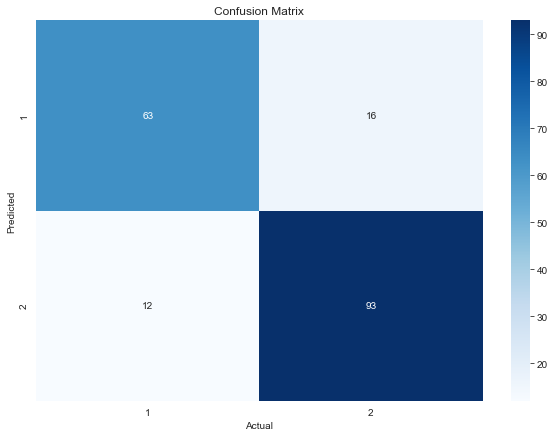

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(conf_matrix_rd):
  labels = ['True', 'prediction']
  df_cm = pd.DataFrame(conf_matrix_rd, index=['1','2'], columns=['1','2'])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title("Confusion Matrix")

  # plt.savefig()

plot_confusion_matrix(conf_matrix_rd)

# Modelo de GradientBoosting

In [53]:
gradmod = GradientBoostingClassifier()
gradmod.fit(X_train, y_train.ravel())

GradientBoostingClassifier()

In [54]:
predictions_grad= Randonmod.predict(X_test)
predictions_grad

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

## Avaliação das métricas do modelo

In [55]:
print(classification_report(y_test,predictions_grad))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        79
           1       0.85      0.89      0.87       105

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



In [56]:
conf_matrix_grad = confusion_matrix(y_test,predictions_grad)
print(conf_matrix_grad )

[[63 16]
 [12 93]]


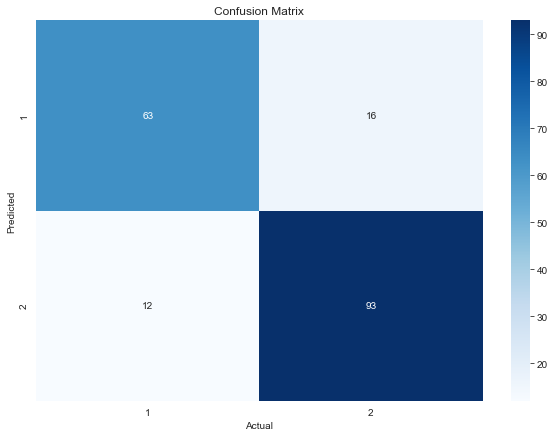

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(conf_matrix_grad):
  labels = ['True', 'prediction']
  df_cm = pd.DataFrame(conf_matrix_grad, index=['1','2'], columns=['1','2'])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title("Confusion Matrix")

  # plt.savefig()

plot_confusion_matrix(conf_matrix_grad)